# This notebook is to visualize the CDC data with UMAP with different sets of CDC features

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
import numpy as np
import seaborn as sns
from src.models.baseline_ML_functions import common_name_to_genus_speices
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from src.models.NN_embedding import embed_features_no_model
le = LabelEncoder()
import seaborn as sns
import matplotlib.pyplot as plt
from sys import platform 
prefix = '../../data_files/'
prefixG = '/Volumes/GoogleDrive'
%matplotlib inline
%load_ext autoreload
%autoreload 2

2023-02-14 20:01:00.636379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Keep only the CDC data with identification

In [2]:
phenotypic_data = pd.read_excel(prefixG+'/Shared drives/SBRL/PhenotypicDataConsolidated.xlsx') #Please see our Data Availability Statement to get access to this file
phenotypic_data_no_null = phenotypic_data[~phenotypic_data.Confirmed_Final_Identification.isna()]
phenotypic_data_no_null = phenotypic_data_no_null.assign(lower_Confirmed_Final_Identification = phenotypic_data_no_null['Confirmed_Final_Identification'].str.lower())
phenotypic_data_confirmed = phenotypic_data_no_null[~phenotypic_data_no_null['lower_Confirmed_Final_Identification'].str.contains('tentative|unidentified|contaminated')]
phenotypic_data_confirmed = phenotypic_data_confirmed[phenotypic_data_confirmed['lower_Confirmed_Final_Identification'] != '(non-viable)']
phenotypic_data_confirmed = phenotypic_data_confirmed.assign(final_id_clean =
                                                             phenotypic_data_confirmed['lower_Confirmed_Final_Identification'].str.replace('\(transferred\)', '').str.strip())
phenotypic_data_confirmed['final_id_clean'] = phenotypic_data_confirmed['final_id_clean'].str.replace('\(non-viable\)', '').str.strip()

In [3]:
phenotypic_data_confirmed.isna().sum()

Culture #                                   0
Culture #Standardized                       0
isolate#                                    0
AltCulture #Standardized                12754
Confirmed_Final_Identification              0
type strain                             12761
Genus                                     112
Card No.                                 1410
Card file #                             12728
Folder Name                              1260
Sheet #                                   724
Question Mark                           11951
Serum?                                  12186
Glu-F                                    5038
Xyl-F                                    5372
Man-F                                    5460
Lact-F                                   4956
Suc-F                                    5451
Malt-F                                   5503
Bk-F                                    12526
Glu-OF                                   8732
Xyl-OF                            

# Getting the columns with the most data available 

In [4]:
cols_to_use = ['Cat','O','MacC/SS = MacC','MaC/SS = SS','Cit/Cet = Cit','TSI:S/B = Slant','TSI:S/B = Butt', 'final_id_clean']
cdc_short = phenotypic_data_confirmed[phenotypic_data_confirmed[cols_to_use].isna().sum(axis = 1) == 0][cols_to_use]

# One hot encode each feature

In [5]:
one_hot_df = pd.get_dummies(cdc_short[cdc_short.columns[:-1]])
one_hot_df['final_id_clean'] = cdc_short['final_id_clean']
one_hot_df.reset_index(drop = True, inplace = True)

## UMAP for dimensional reduction and K means to cluster

In [6]:
reducer = umap.UMAP(n_neighbors = 5, min_dist = 0.5)
umap_embedding = reducer.fit_transform(one_hot_df.iloc[:,:-1])

In [7]:
kmeans = KMeans(n_clusters = 8).fit(one_hot_df.iloc[:,:-1])
labels = kmeans.labels_
umap_w_label = pd.DataFrame(umap_embedding, columns = ['UMAP 1','UMAP 2'])
umap_w_label['labels'] = labels

In [8]:
# see the number of elements in each cluster
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([ 854, 1849, 1860, 1099, 1028, 1195,  682,  555]))

In [9]:
# get PA's index and Se'a index
pa_index = one_hot_df[one_hot_df.final_id_clean == 'pseudomonas aeruginosa'].index
se_index = one_hot_df[one_hot_df.final_id_clean == 'streptococcus epidermidis'].index

## UMAP of the CDC features + annotation of pseudomonas aeruginosa events

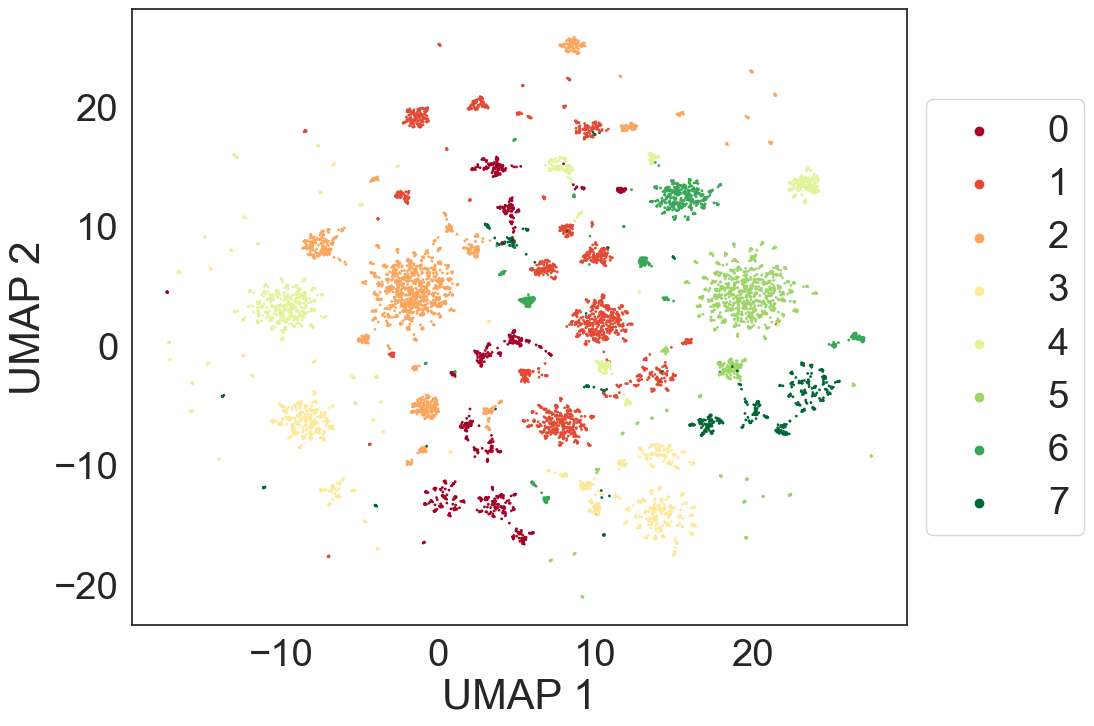

In [10]:
sns.set(font_scale = 2.5)
sns.set_style('white')
plt.figure(figsize = (10, 8))
g = sns.scatterplot(x='UMAP 1',y='UMAP 2', data = umap_w_label, hue = 'labels', 
                palette = 'RdYlGn', linewidth = 0, s = 4, legend = 'full')
g.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1)

In [12]:
umap_w_label.columns

Index(['UMAP 1', 'UMAP 2', 'labels'], dtype='object')

## UMAP of the CDC features + annotation of streptococcus epidermidis events

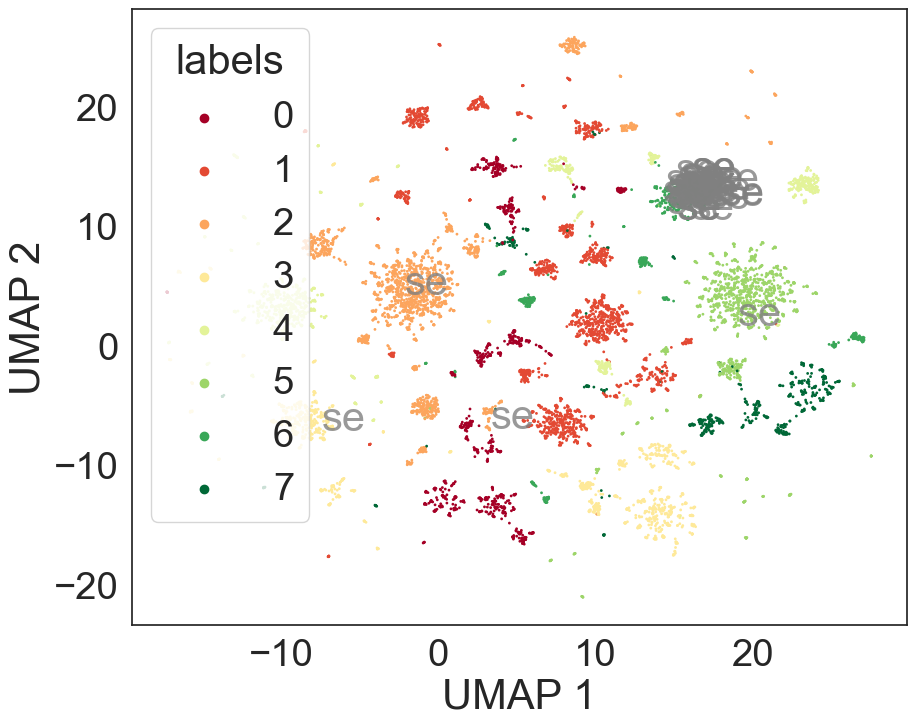

In [13]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x='UMAP 1',y='UMAP 2', data = umap_w_label, hue = 'labels', 
                palette = 'RdYlGn', linewidth = 0, s = 4, legend = 'full')
for index in se_index:
    plt.text(umap_w_label.iloc[index, 0]+0.2, umap_w_label.iloc[index, 1],'se', 
             horizontalalignment='left', size='medium', color='grey', alpha = 0.8)

# Test umap when N/A is converted to 'not tested'

In [14]:
phenotypic_data_confirmed = phenotypic_data_confirmed.fillna('not tested').reset_index(drop = True)

In [15]:
cols_to_use = cols_to_use[:-1]
one_hot_df2 = pd.get_dummies(phenotypic_data_confirmed[cols_to_use]).reset_index(drop = True)
reducer = umap.UMAP(n_neighbors = 5, min_dist = 0.5)
umap_embedding = reducer.fit_transform(one_hot_df2)

In [16]:
kmeans = KMeans(n_clusters = 8).fit(one_hot_df2)
labels = kmeans.labels_
umap_w_label = pd.DataFrame(umap_embedding, columns = ['dim1','dim2'])
umap_w_label['labels'] = labels

In [17]:
# get PA's index and Se'a index
pa_index = phenotypic_data_confirmed[phenotypic_data_confirmed.final_id_clean == 'pseudomonas aeruginosa'].index
se_index = phenotypic_data_confirmed[phenotypic_data_confirmed.final_id_clean == 'streptococcus epidermidis'].index

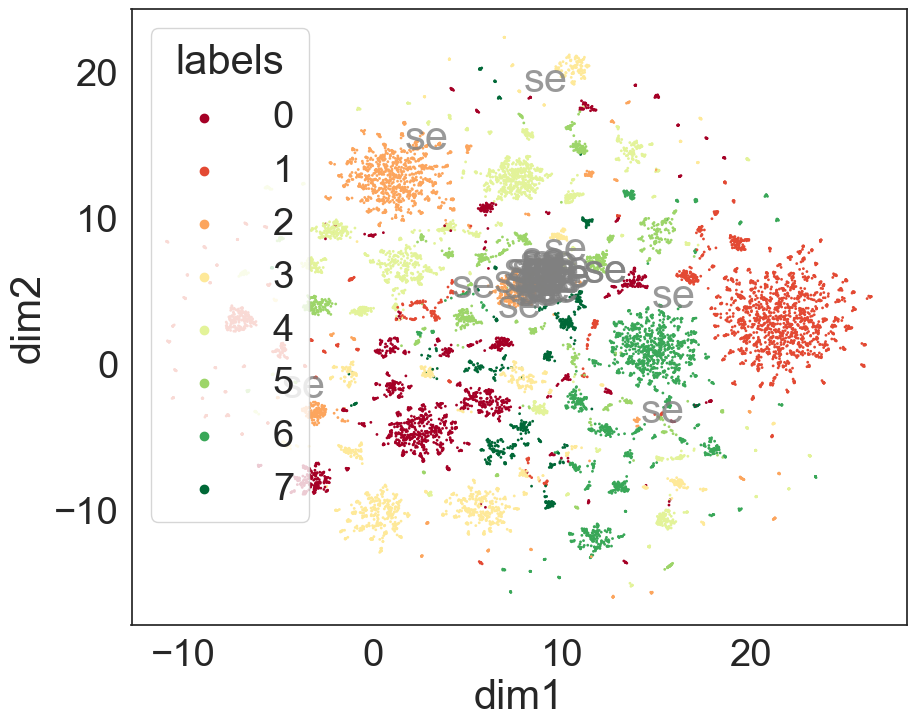

In [19]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x='dim1',y='dim2', data = umap_w_label, hue = 'labels', 
                palette = 'RdYlGn', linewidth = 0, s = 4, legend = 'full')
for index in se_index:
    plt.text(umap_w_label.iloc[index, 0]+0.2, umap_w_label.iloc[index, 1],'se', 
             horizontalalignment='left', size='medium', color='grey', alpha = 0.8)

In [20]:
not_tested_cols = [col for col in one_hot_df2.columns if 'not tested' in col]

In [21]:
not_tested_index_list = []
for col in not_tested_cols:
    not_tested_index_list.append(one_hot_df2[one_hot_df2[col] == 1].index)

In [22]:
not_tested_index = list(set.intersection(*map(set,not_tested_index_list)))

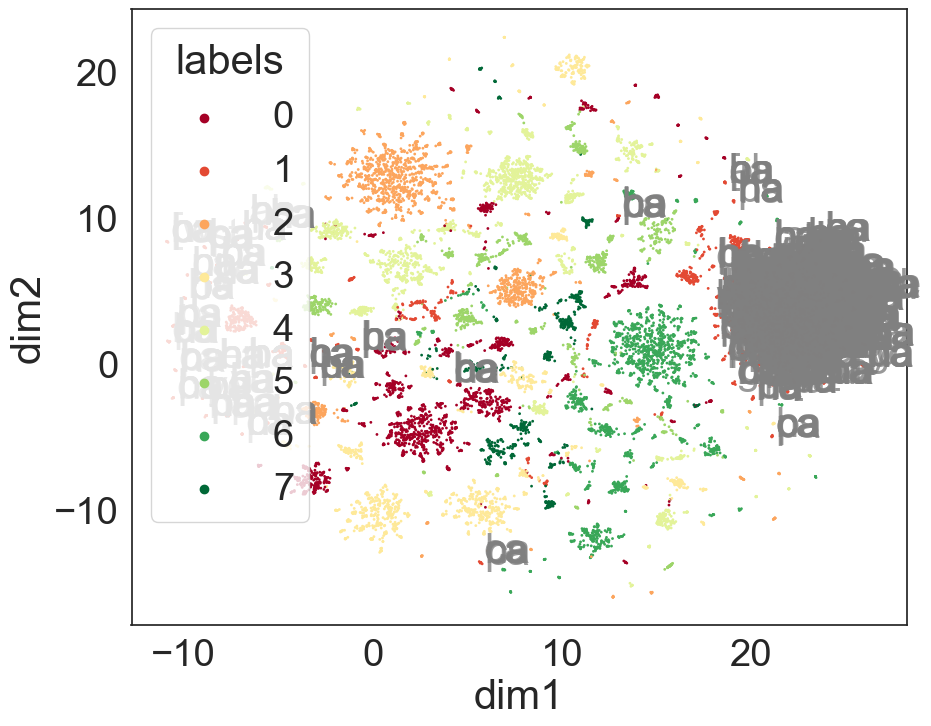

In [23]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x='dim1',y='dim2', data = umap_w_label, hue = 'labels', 
                palette = 'RdYlGn', linewidth = 0, s = 4, legend = 'full')
for index in not_tested_index:
    plt.text(umap_w_label.iloc[index, 0]+0.2, umap_w_label.iloc[index, 1],phenotypic_data_confirmed['final_id_clean'][index][:2], 
             horizontalalignment='left', size='medium', color='grey', alpha = 0.8)

# Plot binary features and color-code by species name for the manuscript

In [26]:
from src.preprocessing.load_cdc_data import sbrl_preprocess
phenotypic_data_confirmed = sbrl_preprocess()

In [27]:
clean_valid_genus_species = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/cdc_genus_species_valid_data.csv')

In [28]:
features_to_use = clean_valid_genus_species.columns[:-2]
print(features_to_use)

Index(['MaC/SS = SS', 'MacC/SS = MacC', 'TSI:H2S =paper', 'TSI:H2S = butt', 'Cat', 'O', 'TSI:S/B = Slant', 'TSI:S/B = Butt'], dtype='object')


In [29]:
index_to_keep = phenotypic_data_confirmed[phenotypic_data_confirmed[features_to_use].isna().sum(axis = 1) == 0].index
cdc_short3 = phenotypic_data_confirmed.loc[index_to_keep,features_to_use]
cdc_short3['final_id_clean'] = phenotypic_data_confirmed.loc[index_to_keep,'final_id_clean']
cdc_short3 = cdc_short3.reset_index(drop = True)

In [30]:
cdc_short3.final_id_clean.value_counts()[15:20].index

Index(['pseudomonas', 'vibrio parahaemolyticus', 'capnocytophaga', 'serratia', 'oligella urethralis'], dtype='object')

In [31]:
# manually selected most abundant instances that have both genus and species present
abundant_species = ['pasteurella multocida', 'pseudomonas aeruginosa', 'pseudomonas maltophilia', 
                    'haemophilus aphrophilus', 'pseudomonas pickettii [5a-1 and 5a-2]', 'moraxella nonliquefaciens', 
                    'capnocytophaga canimorsus [df-2]', 'eikenella corrodens [hb-1]', 
                    'methylobacterium extorquens', 'oligella ureolytica [4e]',
                    'vibrio parahaemolyticus','oligella urethralis']

In [32]:
cdc_abundant = cdc_short3[cdc_short3.final_id_clean.isin(abundant_species)]

In [33]:
encoded_cols3 = []
for col in cdc_short3.columns[:-1]:
    encoded_cols3.append(le.fit_transform(cdc_abundant[col]))

In [34]:
# Encode the ID to use as the labels
cdc_abundant = cdc_abundant.assign(encoded_final_id_clean = le.fit_transform(cdc_abundant['final_id_clean']))
y_one_hot3=to_categorical(cdc_abundant.encoded_final_id_clean) 
train_index3, test_index3 = train_test_split(cdc_abundant.index, test_size=0.2)

In [35]:
pre_train_concat3, pre_train_emb3 = embed_features_no_model(encoded_cols3, 1)
pre_train_emb_df = pd.DataFrame(pre_train_emb3, columns = ['dim1','dim2'])
pre_train_emb_df['final_id_clean'] = cdc_abundant['final_id_clean'].tolist()

2023-02-14 20:10:21.254903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
pre_train_emb_df.final_id_clean = pre_train_emb_df.final_id_clean.str.replace('\[[^()]*\]','').str.strip()

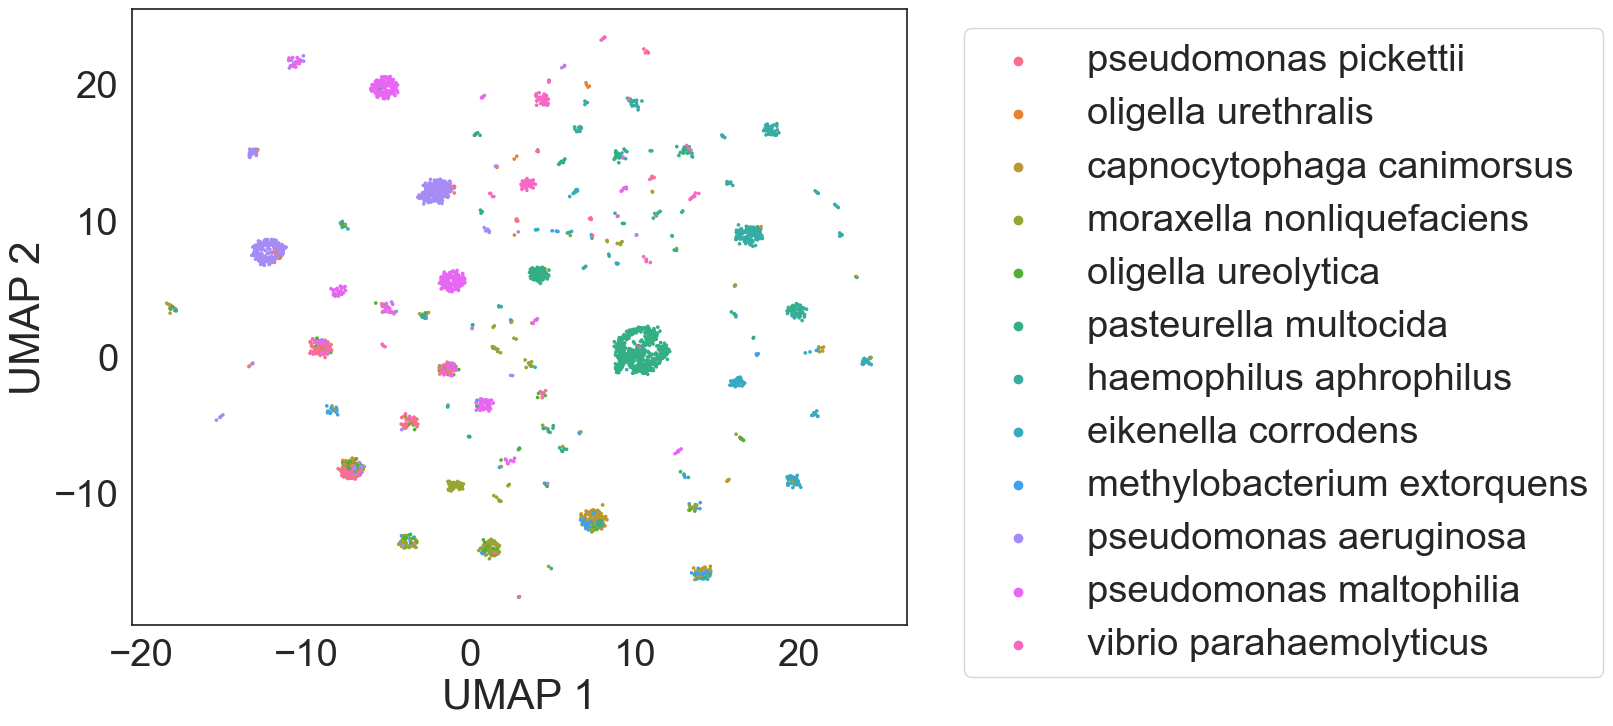

In [37]:
plt.figure(figsize = (10, 8))
sns.set(font_scale = 2.5)
sns.set_style('white')
sns.scatterplot(x='dim1',y='dim2', data = pre_train_emb_df, hue = 'final_id_clean', 
                palette = 'husl', linewidth = 0, s = 7, legend = 'full')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)